# Loading and labeling the data

In [1]:
import numpy as np
import pandas as pd
import rrcf
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
#df = pd.DataFrame(taxi)
df = pd.read_csv('D:/DataScience/first-repository/raw_data/nyc_taxi.csv', index_col=0)
df.index = pd.to_datetime(df.index)
data = df['data'].astype(float).values

In [4]:
df

,data
datetime,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


In [5]:
events = {
    'independence_day' : ('2014-07-04 00:00:00',
                          '2014-07-07 00:00:00'),
    'labor_day'        : ('2014-09-01 00:00:00',
                          '2014-09-02 00:00:00'),
    'labor_day_parade' : ('2014-09-06 00:00:00',
                          '2014-09-07 00:00:00'),
    'nyc_marathon'     : ('2014-11-02 00:00:00',
                          '2014-11-03 00:00:00'),
    'thanksgiving'     : ('2014-11-27 00:00:00',
                          '2014-11-28 00:00:00'),
    'christmas'        : ('2014-12-25 00:00:00',
                          '2014-12-26 00:00:00'),
    'new_year'         : ('2015-01-01 00:00:00',
                          '2015-01-02 00:00:00'),
    'blizzard'         : ('2015-01-26 00:00:00',
                          '2015-01-28 00:00:00')
}
df['event'] = np.zeros(len(df))
for event, duration in events.items():
    start, end = duration
    df.loc[start:end, 'event'] = 1

# Running RRCF

In [6]:
# Set tree parameters
num_trees = 200
shingle_size = 48
tree_size = 1000

In [7]:
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(data, size=shingle_size)
points = np.vstack([point for point in points])
n = points.shape[0]
sample_size_range = (n // tree_size, tree_size)

In [8]:
forest = []
while len(forest) < num_trees:
    ixs = np.random.choice(n, size=sample_size_range,
                           replace=False)
    trees = [rrcf.RCTree(points[ix], index_labels=ix)
             for ix in ixs]
    forest.extend(trees)
    
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)

for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                        for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
    
avg_codisp /= index
avg_codisp.index = df.iloc[(shingle_size - 1):].index

# Running Isolation Forest

In [10]:
contamination = df['event'].sum()/len(df)
IF = IsolationForest(n_estimators=num_trees,
                     contamination=contamination,
                     behaviour='new',
                     random_state=0)
IF.fit(points)
if_scores = IF.score_samples(points)
if_scores = pd.Series(-if_scores,
                      index=(df
                             .iloc[(shingle_size - 1):]
                             .index))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:255: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


# Ploting the results

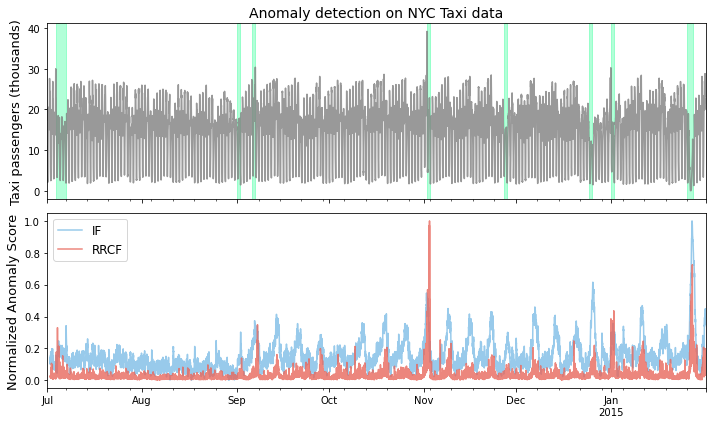

In [13]:
# Normalize anomaly scores to (0, 1)
avg_codisp = ((avg_codisp - avg_codisp.min())
              / (avg_codisp.max() - avg_codisp.min()))
if_scores = ((if_scores - if_scores.min())
              / (if_scores.max() - if_scores.min()))
              
fig, ax = plt.subplots(2, figsize=(10, 6))
(df['data'] / 1000).plot(ax=ax[0], color='0.5',
                            alpha=0.8)
if_scores.plot(ax=ax[1], color='#7EBDE6', alpha=0.8,
               label='IF')
avg_codisp.plot(ax=ax[1], color='#E8685D', alpha=0.8,
                label='RRCF')
ax[1].legend(frameon=True, loc=2, fontsize=12)

for event, duration in events.items():
    start, end = duration
    ax[0].axvspan(start, end, alpha=0.3,
                  color='springgreen')

ax[0].set_xlabel('')
ax[1].set_xlabel('')

ax[0].set_ylabel('Taxi passengers (thousands)', size=13)
ax[1].set_ylabel('Normalized Anomaly Score', size=13)
ax[0].set_title('Anomaly detection on NYC Taxi data',
                size=14)

ax[0].xaxis.set_ticklabels([])

ax[0].set_xlim(df.index[0], df.index[-1])
ax[1].set_xlim(df.index[0], df.index[-1])
plt.tight_layout()